Random Forest:
MAE: 28928.55
R2 Score: 0.52

Linear Regression:
MAE: 29684.40
R2 Score: 0.51



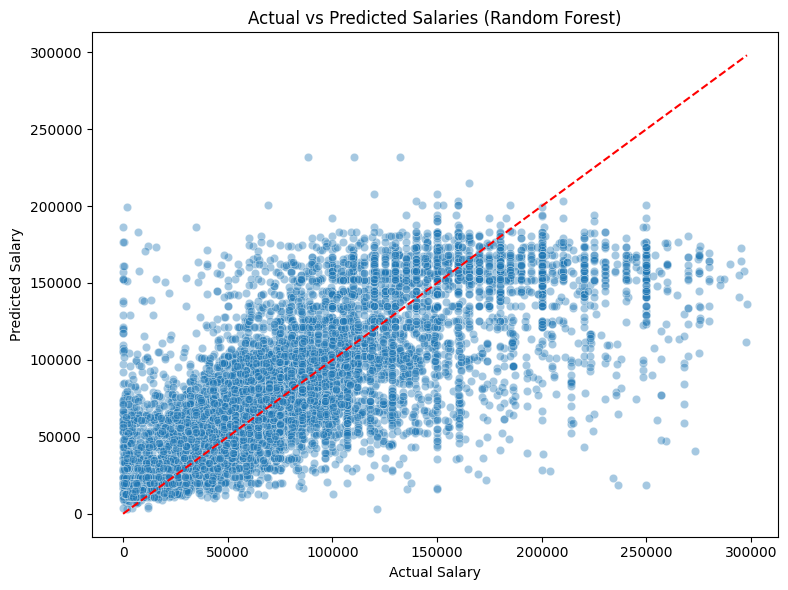

Model results saved to ../processed/model_results.csv
Actual vs Predicted data saved to ../processed/actual_vs_predicted.csv
Trained models saved to ../model/random_forest_model.pkl and ../model/linear_regression_model.pkl


['../model/scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load cleaned dataset
df = pd.read_csv("../processed/cleaned_data.csv")

# Features and Target
X = df.drop("ConvertedCompYearly", axis=1)
y = df["ConvertedCompYearly"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Model 1: Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# --- Model 2: Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print scores
print("Random Forest:")
print(f"MAE: {mae_rf:.2f}")
print(f"R2 Score: {r2_rf:.2f}\n")

print("Linear Regression:")
print(f"MAE: {mae_lr:.2f}")
print(f"R2 Score: {r2_lr:.2f}\n")

# --- Actual vs Predicted Plot (Random Forest) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salaries (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

# 1. Load Data
df = pd.read_csv("../processed/cleaned_data.csv")
X = df.drop("ConvertedCompYearly", axis=1)
y = df["ConvertedCompYearly"]

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define Pipelines
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])

# 4. Train Models
pipeline_rf.fit(X_train, y_train)
pipeline_lr.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)

# 5. Evaluate Models
def eval_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2

mae_rf, r2_rf = eval_model(pipeline_rf, X_test, y_test)
mae_lr, r2_lr = eval_model(pipeline_lr, X_test, y_test)
mae_xgb, r2_xgb = eval_model(pipeline_xgb, X_test, y_test)

print("\nRandom Forest: MAE = {:.2f}, R2 = {:.2f}".format(mae_rf, r2_rf))
print("Linear Regression: MAE = {:.2f}, R2 = {:.2f}".format(mae_lr, r2_lr))
print("XGBoost: MAE = {:.2f}, R2 = {:.2f}\n".format(mae_xgb, r2_xgb))

# 6. Save Pipelines
os.makedirs("models", exist_ok=True)
joblib.dump(pipeline_rf, "../models/rf_pipeline.pkl")
joblib.dump(pipeline_lr, "../models/lr_pipeline.pkl")
joblib.dump(pipeline_xgb, "../models/xgb_pipeline.pkl")

# 7. Save Feature Columns (for inference in app)
features = list(X.columns)
joblib.dump(features, "../models/features.pkl")

print("All models and feature list saved in models/ directory.")

# 8. (Optional) Save evaluation results
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_xgb],
    'R2 Score': [r2_rf, r2_lr, r2_xgb]
})
results.to_csv('..processed/model_results.csv', index=False)


Random Forest: MAE = 28925.90, R2 = 0.52
Linear Regression: MAE = 29684.40, R2 = 0.51
XGBoost: MAE = 28265.38, R2 = 0.54

All models and feature list saved in models/ directory.
